# Homework 3:
Duo Xu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pickle
from scipy import optimize as opt

## Problem 1. One-sigma uncertainty ellipses of linear fitting problem

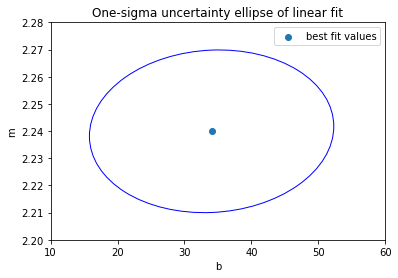

In [2]:
def fit(x, y, sigma):
    ATCA = np.ones((2, 2))
    s = sigma**2
    ATCA[0][0] = sum(1/s)
    ATCA[0][1] = sum(x/s)
    ATCA[1][0] = sum(x/s)
    ATCA[1][1] = sum(x**2/s)
    inv = np.ones((2,2))
    det = ATCA[0][0]*ATCA[1][1] - ATCA[0][1]*ATCA[1][0]
    inv[0][0] = ATCA[1][1]/det
    inv[0][1] = -ATCA[0][1]/det
    inv[1][0] = -ATCA[1][0]/det
    inv[1][1] = ATCA[0][0]/det
    ATCY = np.ones((2,1))
    ATCY[0][0] = sum(y/s)
    ATCY[1][0] = sum(x*y/s)
    return np.matmul(inv, ATCY), inv

datax, datay, sigmay, sigmax, rhoxy = np.loadtxt('data.txt', unpack = True)

para = fit(datax[4:], datay[4:], sigmay[4:])
cov = para[1]
eig = np.linalg.eig(cov)
w = 2*np.sqrt(eig[0][0])
h = 2*np.sqrt(eig[0][1])
theta = np.arctan(eig[1][0][1]/eig[1][0][0])

ax = plt.subplot()
ellipse = Ellipse(xy=para[0], width=w, height=h, angle=theta, facecolor='none', edgecolor='blue')
ax.add_patch(ellipse)
plt.ylim(2.2, 2.28)
plt.xlim(10, 60)
plt.title('One-sigma uncertainty ellipse of linear fit')
plt.xlabel('b')
plt.ylabel('m')
plt.scatter(*para[0], label = 'best fit values')
plt.legend()

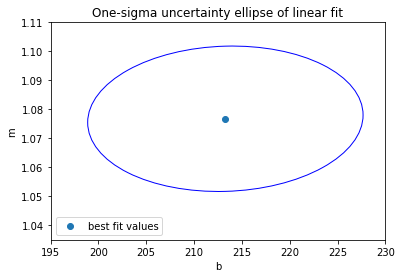

In [3]:
para2 = fit(datax, datay, sigmay)
cov2 = para2[1]
eig2 = np.linalg.eig(cov2)
w2 = 2*np.sqrt(eig2[0][0])
h2 = 2*np.sqrt(eig2[0][1])
theta2 = np.arctan(eig2[1][0][1]/eig2[1][0][0])

plt.figure()
ax = plt.subplot()
ellipse2 = Ellipse(xy=para2[0], width=w2, height=h2, angle=theta2, facecolor='none', edgecolor='blue')
ax.add_patch(ellipse2)
plt.ylim(1.035, 1.11)
plt.xlim(195, 230)
plt.title('One-sigma uncertainty ellipse of linear fit')
plt.xlabel('b')
plt.ylabel('m')
plt.scatter(*para2[0], label = 'best fit values')
plt.legend()

The locations of the best fit values of the two problems are vastly different but the sizes of the one-sigma uncertainty ellipses are not. This is due to the uncertainty being entirely implied by the covariance matrices, but in the second model, the covariance matrices does not correctly represent the uncertainties of the fit as the model is "not good".

## Problem 2. Standard uncertainty on the period T of sinusoidal signal

Text(0, 0.5, 'Profiled LF')

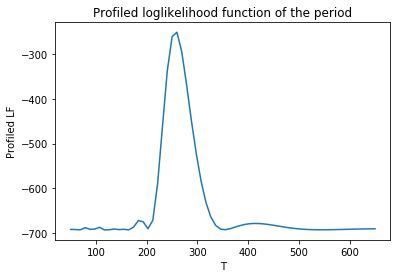

In [4]:
with open("data.pkl", "rb") as handle:
    data = pickle.load(handle).T
    
def mu(t, B, A1, A2, A3, A4, T):
    return (B + A1*np.cos(2*np.pi*t/100) + A2*np.sin(2*np.pi*t/100) +
            A3*np.cos(2*np.pi*t/T) + A4*np.sin(2*np.pi*t/T))
    
def loglike(t, paras, data, info):
    B, A1, A2, A3, A4, T = paras
    y = data
    sigma = info
    temp = y - mu(t, B, A1, A2, A3, A4, T)
    summ = np.sum(temp**2/sigma)
    return -0.5*summ

def llt(T, t, paras, data, info):
    B, A1, A2, A3, A4 = paras
    y = data
    sigma = info
    temp = y - mu(t, B, A1, A2, A3, A4, T)
    summ = np.sum(temp**2/sigma)
    return 0.5*summ

def fitT(T, t, data, info):
    def ll(paras):
        return llt(T, t, paras, data, info)
    x0 = [1,1,1,1,1]
    return opt.minimize(ll, x0).x

T = np.linspace(50, 650, 64)
val = []
for i in range(len(T)):
    paras = fitT(T[i], data[0], data[12], data[1])
    val.append(loglike(data[0], [paras[0], paras[1], paras[2], paras[3], 
                                paras[4], T[i]], data[12], data[1]))
maxind = val.index(max(val))
maxT = (T[maxind])

plt.plot(T, val)
plt.title('Profiled loglikelihood function of the period')
plt.xlabel('T')
plt.ylabel('Profiled LF')

In [5]:
top3 = sorted(zip(val, T), reverse=True)[:3]
Ttop3 = []
for i in range(3):
    Ttop3.append(top3[i][1])
Ttop3 = np.array(Ttop3)
LFtop3 = []
for i in range(3):
    LFtop3.append(top3[i][0])
LFtop3 = np.array(LFtop3)
fit = np.polyfit(Ttop3, -1*LFtop3, 2)
print('The uncertainty on the period T is ' + str((1/fit[0])**0.5))

The uncertainty on the period T is 1.8282539578470696


By fitting a parabola using the top three points of the profiled loglikelihood function, we obtain $1/\sigma_T^2 = -\frac{d^2L}{dT^2}$ as the coeffient of the degree two term in the polynomial. The uncertainty on the period T obtained by this analysis of the likelihood function is roughly $ \sigma_T = 1.8$.

## Problem 3. Metropolis-Hastings MCMC

### Problem 2 from  https://arxiv.org/abs/1710.06068

Text(0, 0.5, 'f(x) or histogram density')

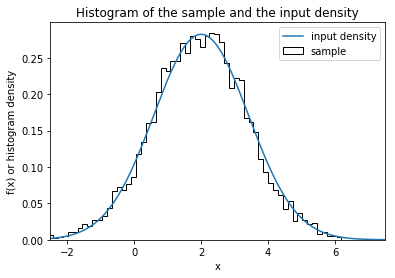

In [6]:
def f(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*(x - mu)**2/sigma**2)

N = 10000
x = 0
sample = []
for i in range(N):
    xnew = np.random.normal(x, 1)
    r = f(xnew, 2, 2**0.5)/f(x, 2, 2**0.5)
    if r > np.random.rand():
        x = xnew
    sample.append(x)

z = np.linspace(-7.5, 10, 1024)
plt.hist(sample, bins = 64, histtype='step', color = 'black', density = True, label = 'sample')
plt.plot(z, f(z, 2, 2**0.5), label = 'input density')
plt.xlim(-2.5, 7.5)
plt.title('Histogram of the sample and the input density')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x) or histogram density')

### Problem 4 from  https://arxiv.org/abs/1710.06068

#### (a) 2D covariant Gaussian input density

Text(0, 0.5, 'y')

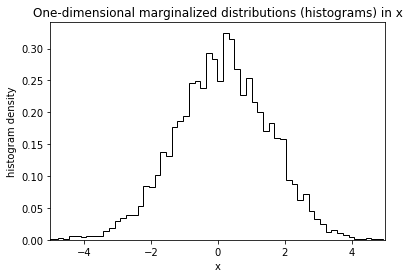

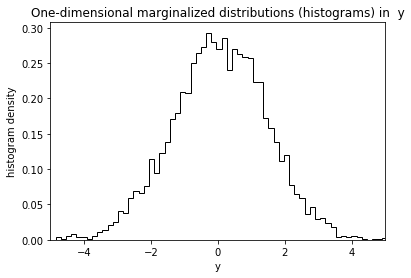

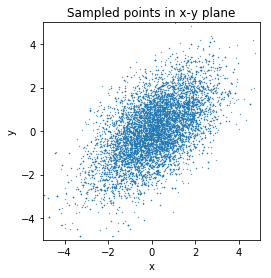

In [7]:
def fxy(x, V, mu):
    detV = np.linalg.det(V)
    invV = np.linalg.inv(V)
    xT = np.transpose(x-mu)
    temp = np.matmul(invV, x-mu)
    return (1/(detV**0.5*2*np.pi))*np.exp(-0.5*np.matmul(xT, temp))

V = [[2.0, 1.2], [1.2, 2.0]]

N = 10000
x = 0
y = 0
X = np.append(x, y)
samplex = []
sampley = []
for i in range(N):
    xnew = np.random.normal(x, 1)
    ynew = np.random.normal(y, 1)
    Xnew = np.append(xnew, ynew)
    r = fxy(Xnew, V, 0)/fxy(X, V, 0)
    if r > np.random.rand():
        x = xnew
        y = ynew
        X = np.append(x, y)
    samplex.append(x)
    sampley.append(y)

fig, ax = plt.subplots()
ax.hist(samplex, bins = 64, histtype='step', color = 'black', density = True)
plt.xlim(-5, 5)
plt.title('One-dimensional marginalized distributions (histograms) in x')
plt.xlabel('x')
plt.ylabel('histogram density')
fig, ax = plt.subplots()
ax.hist(sampley, bins = 64, histtype='step', color = 'black', density = True)
plt.xlim(-5, 5)
plt.title('One-dimensional marginalized distributions (histograms) in  y')
plt.xlabel('y')
plt.ylabel('histogram density')
fig, ax = plt.subplots()
ax.scatter(samplex,sampley, s = 0.1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
ax.set_aspect(1)
plt.title('Sampled points in x-y plane')
plt.xlabel('x')
plt.ylabel('y')

#### (b) 2D uniform input density

Text(0, 0.5, 'y')

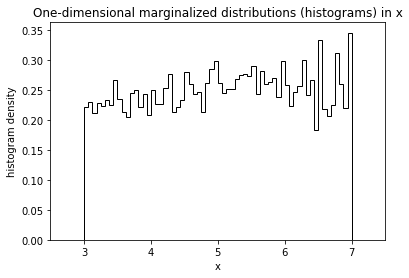

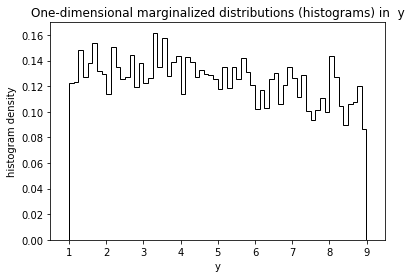

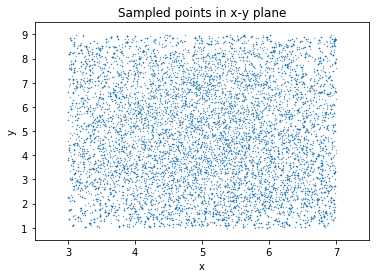

In [8]:
def box(x, y):
    if x > 3 and x < 7 and y > 1 and y < 9:
        return 1
    else:
        return 0

N = 10000
x2 = 5
y2 = 5
X2 = np.append(x2, y2)
samplex2 = []
sampley2 = []
for i in range(N):
    xnew2 = np.random.normal(x2, 1)
    ynew2 = np.random.normal(y2, 1)
    Xnew2 = np.append(xnew2, ynew2)
    r = box(*Xnew2)/(box(*X2) + 1e-4)
    if r > np.random.rand():
        x2 = xnew2
        y2 = ynew2
        X2 = np.append(x2, y2)
    samplex2.append(x2)
    sampley2.append(y2)

fig, ax = plt.subplots()
ax.hist(samplex2, bins = 64, histtype='step', color = 'black', density = True)
plt.xlim(2.5, 7.5)
plt.title('One-dimensional marginalized distributions (histograms) in x')
plt.xlabel('x')
plt.ylabel('histogram density')
fig, ax = plt.subplots()
ax.hist(sampley2, bins = 64, histtype='step', color = 'black', density = True)
plt.xlim(0.5, 9.5)
plt.title('One-dimensional marginalized distributions (histograms) in  y')
plt.xlabel('y')
plt.ylabel('histogram density')
fig, ax = plt.subplots()
ax.scatter(samplex2,sampley2, s = 0.1)
plt.xlim(2.5, 7.5)
plt.ylim(0.5, 9.5)
plt.title('Sampled points in x-y plane')
plt.xlabel('x')
plt.ylabel('y')

### Problem 10 from  https://arxiv.org/abs/1710.06068

The empirical means of the four segments are [2.0119517231918222, 1.9730434315456251, 1.8287404258949373, 1.9444593658539073], the empirical variances of the four segments are [1.8705391668641251, 1.938830031182903, 2.0634791572989433, 2.0705017072808003].


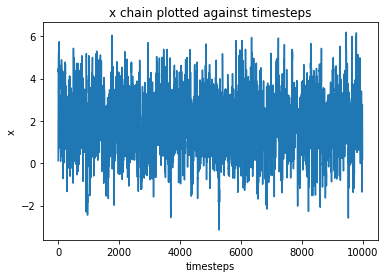

In [9]:
plt.plot(range(N), sample)
plt.title('x chain plotted against timesteps')
plt.xlabel('timesteps')
plt.ylabel('x')
x1 = np.array(sample[:N//4])
x2 = np.array(sample[N//4:N//2])
x3 = np.array(sample[N//2:3*N//4])
x4 = np.array(sample[3*N//4:])
xchain = [x1, x2, x3, x4]
means = []
variances = []
for i in range(4):
    means.append(sum(xchain[i])/(N/4))
    variances.append(sum((xchain[i] - means[i])**2)/(N/4))

print('The empirical means of the four segments are ' + str(means) + ', the empirical variances of the four segments are ' + str(variances) + '.')

The empirical means and variances have no distinct trends as functions of timesteps. This is expected as the Metropolis-Hastings algorithm is a Markov Chain Monte Carlo algorithm, where each step only depends on the last step with a fixed width gaussian centered at the last step.